In [45]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd

In [131]:
df_fact = pd.DataFrame([
    ['leonardo', 0.5, 0],
    ['leonardo', 2.5, 1],
    ['leonardo', 3.2, 1],
    ['bruno', 3.1, 1],
    ['carla', 1, 1],
    ['carla', 0.1, 0],
    ['carla', 0.2, 0],
    ['maria', 1, 0],
    ['maria', 3, 1],
    ['jose', 1.5, 0],
    ['jose', 2.4, 0],
    ['jose', 2.9, 1],
    ['pedro', 1.4, 1],
], columns = ['name', 'liters_of_beer', 'wasted'])
df_fact

,name,liters_of_beer,wasted
0,leonardo,0.5,0
1,leonardo,2.5,1
2,leonardo,3.2,1
3,bruno,3.1,1
4,carla,1.0,1
5,carla,0.1,0
6,carla,0.2,0
7,maria,1.0,0
8,maria,3.0,1
9,jose,1.5,0


In [170]:
df_dimension_weight = pd.DataFrame([
    ['leonardo', 60],
    ['bruno', 75],
    ['carla', 50],
    ['maria', 85],
    ['jose', 97],
    ['pedro', 80],
], columns = ['name', 'weight'])
df_dimension_weight


,name,weight
0,leonardo,60
1,bruno,75
2,carla,50
3,maria,85
4,jose,97
5,pedro,80


# Without feature store

<Axes: xlabel='liters_of_beer', ylabel='weight'>

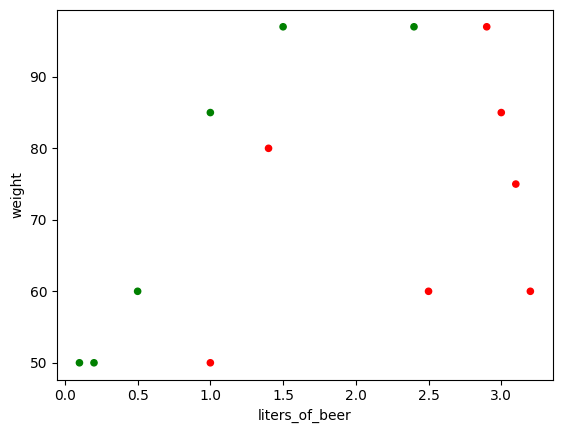

In [171]:
# Data preparation (joining with another table)
df = df_fact.set_index('name').join(df_dimension_weight.set_index('name'))
df.reset_index(inplace=True)

df.plot.scatter('liters_of_beer', 'weight', c=['green' if wasted == 0 else 'red' for wasted in df['wasted']])

In [ ]:
# Do the ML training thing
X_train, X_test, y_train, y_test = train_test_split(df.drop(['wasted', 'name'], axis=1), df['wasted'])
model = RandomForestRegressor(n_estimators=1, max_depth=4, max_features=3).fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

In [ ]:
# Make an inference
df_fact_new = pd.DataFrame([
    ['leonardo', 0.1],
    ['leonardo', 5],
], columns=['name', 'liters_of_beer'])

df_new = df_fact_new.set_index('name').join(df_dimension_weight.set_index('name'))
model.predict(df_new)

# Using Feast

running locally, with file-based storage

In [25]:
#!pip install feast

In [26]:
#!feast init "feast_tutorial"

In [ ]:
# TODO

# Using Databricks
This code only runs within the databricks notebooks

suposes the prior existance of:
1. Catalog named `test_databricks`
2. Schema named `default`

The workspace should be Premium or Enterprise

In [ ]:
from databricks import feature_store
from databricks.feature_engineering import FeatureLookup
import mlflow
mlflow.autolog()
mlflow.set_experiment("/Users/lsbenitezpereira@gmail.com/tutorial_feature_store")

In [ ]:
# Register feature
spark.sql('''
CREATE TABLE IF NOT EXISTS test_databricks.default.dimension_weight(
    name STRING NOT NULL,
    weight BIGINT,
    CONSTRAINT name_pk PRIMARY KEY(name)
);
''')
spark.createDataFrame(df_dimension_weight).write.format("delta").mode("overwrite").option("mergeSchema", "true").saveAsTable("test_databricks.default.dimension_weight")

In [ ]:
# Prepare data (join facts with precomputed dimensions)
fs = feature_store.FeatureStoreClient()
dataset_with_feature_metadata = fs.create_training_set(
    df=spark.createDataFrame(df_fact),
    feature_lookups= [
        FeatureLookup(
            table_name='default.dimension_weight',
            feature_names=['weight'],
            lookup_key='name',
        )
    ],
    label = 'wasted',
    exclude_columns = ['name'],
)
df = dataset_with_feature_metadata.load_df().toPandas()
df

In [ ]:
with mlflow.start_run() as run:
    run_id = run.info.run_id

    # Do the ML thing
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['wasted'], axis=1), df['wasted'])
    model = RandomForestRegressor(n_estimators=1, max_depth=5, max_features=3).fit(X_train, y_train)
    mean_absolute_error(y_test, model.predict(X_test))

    fs.log_model(
        model=model,
        artifact_path="model",
        flavor=mlflow.sklearn,
        training_set=dataset_with_feature_metadata,  # This is the magic step
    )

In [ ]:
# Make an inference
# No need to join anymore... MIRACLE!!!
# The need of a join is already captured in the mlflow model metadata
# Therefore, MLflow can perform it automatically for you
# Plus lineage, point-in-time join, etc

df_fact_new = pd.DataFrame([
    ['leonardo', 0.1],
    ['leonardo', 5],
], columns=['name', 'liters_of_beer'])

fs.score_batch(
    model_uri=f"runs:/{run_id}/model",
    df=spark.createDataFrame(df_fact_new),
).show()